# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record



In [150]:
import pandas as pd
import numpy as np
import math
import json
%matplotlib inline


import seaborn as sns
import scipy.stats as stats
import matplotlib.pyplot as plt
from scipy.linalg import svd
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LinearRegression
from sklearn.metrics import accuracy_score


# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

In [151]:
portfolio.head()


,reward,channels,difficulty,duration,offer_type,id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7


In [152]:
profile.head()


,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN


In [153]:
transcript.head()

,person,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0


In [154]:
# Check basic statistics
print(profile.describe())
print(portfolio.describe())
print(transcript.describe())


                age  became_member_on         income
count  17000.000000      1.700000e+04   14825.000000
mean      62.531412      2.016703e+07   65404.991568
std       26.738580      1.167750e+04   21598.299410
min       18.000000      2.013073e+07   30000.000000
25%       45.000000      2.016053e+07   49000.000000
50%       58.000000      2.017080e+07   64000.000000
75%       73.000000      2.017123e+07   80000.000000
max      118.000000      2.018073e+07  120000.000000
          reward  difficulty   duration
count  10.000000   10.000000  10.000000
mean    4.200000    7.700000   6.500000
std     3.583915    5.831905   2.321398
min     0.000000    0.000000   3.000000
25%     2.000000    5.000000   5.000000
50%     4.000000    8.500000   7.000000
75%     5.000000   10.000000   7.000000
max    10.000000   20.000000  10.000000
                time
count  306534.000000
mean      366.382940
std       200.326314
min         0.000000
25%       186.000000
50%       408.000000
75%       528.00

## Data Cleaning

In [155]:
# Extract offer id from value column where applicable
transcript['offer_id'] = transcript['value'].apply(lambda x: x.get('offer id'))
transcript['amount'] = transcript['value'].apply(lambda x: x.get('amount', 0))

print(transcript.head())

                             person           event  \
0  78afa995795e4d85b5d9ceeca43f5fef  offer received   
1  a03223e636434f42ac4c3df47e8bac43  offer received   
2  e2127556f4f64592b11af22de27a7932  offer received   
3  8ec6ce2a7e7949b1bf142def7d0e0586  offer received   
4  68617ca6246f4fbc85e91a2a49552598  offer received   

                                              value  time  \
0  {'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}     0   
1  {'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}     0   
2  {'offer id': '2906b810c7d4411798c6938adc9daaa5'}     0   
3  {'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}     0   
4  {'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}     0   

                           offer_id  amount  
0  9b98b8c7a33c4b65b9aebfe6a799e6d9     0.0  
1  0b1e1539f2cc45b7b9fa7c272da2e1d7     0.0  
2  2906b810c7d4411798c6938adc9daaa5     0.0  
3  fafdcd668e3743c1bb461111dcafc2a4     0.0  
4  4d5c57ea9a6940dd891ad53e9dbe8da0     0.0  


In [156]:
# Assuming 'offer_id' is None for transactions without associated offers
transactions_without_offers = transcript[(transcript['event'] == 'transaction') & (transcript['offer_id'].isna())]

# Calculate spending without offers for each user
# Ensure that 'person' is the correct identifier in the transactions DataFrame
user_spending_without_offers = transactions_without_offers.groupby('person')['amount'].sum().reset_index()
user_spending_without_offers.rename(columns={'amount': 'spending_without_offers', 'person': 'id'}, inplace=True)

# Merge this data back into the profile DataFrame using 'id' as the key
profile = profile.merge(user_spending_without_offers, on='id', how='left')
profile['spending_without_offers'].fillna(0, inplace=True)

C:\Users\kilgo\AppData\Local\Temp\ipykernel_37644\3287058969.py:11: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  profile['spending_without_offers'].fillna(0, inplace=True)


In [157]:
# Clean profile data
profile['became_member_on'] = pd.to_datetime(profile['became_member_on'], format='%Y%m%d')
profile['age'] = profile['age'].replace(118, np.nan)  # Assuming '118' means missing age
profile.dropna(inplace=True)  # Dropping rows with any missing values


## 

In [159]:
def create_user_offer_matrix(transcript):
    
    # Filter only 'offer received' and 'offer completed' events
    offer_received = transcript[transcript['event'] == 'offer received']
    offer_completed = transcript[transcript['event'] == 'offer completed']

    # Create a matrix of users and offers using the correct key 'offer_id'
    user_offer_matrix = offer_received.pivot_table(index='person', columns='offer_id', values='time', aggfunc='size', fill_value=0)
    user_offer_matrix = (user_offer_matrix > 0).astype(int)  # Convert to binary

    # Incorporate information from offer completed
    completed_matrix = offer_completed.pivot_table(index='person', columns='offer_id', values='time', aggfunc='size', fill_value=0)
    completed_matrix = (completed_matrix > 0).astype(int)  # Convert to binary

    # Update the received offers with completed offers information
    user_offer_matrix.update(completed_matrix)

    return user_offer_matrix

# Now call the function
user_offer_matrix = create_user_offer_matrix(transcript)



In [160]:
def funk_svd(matrix, latent_features=12, learning_rate=0.0001, iterations=100):
    # Initialize user and offer matrices with random values
    n_users, n_offers = matrix.shape
    user_mat = np.random.normal(scale=1./latent_features, size=(n_users, latent_features))
    offer_mat = np.random.normal(scale=1./latent_features, size=(n_offers, latent_features))
    
    # Perform gradient descent
    for iteration in range(iterations):
        for i in range(n_users):
            for j in range(n_offers):
                if matrix[i, j] > 0:  # only update if interaction is known
                    error = matrix[i, j] - np.dot(user_mat[i, :], offer_mat[j, :])
                    for k in range(latent_features):
                        user_mat[i, k] += learning_rate * (2 * error * offer_mat[j, k])
                        offer_mat[j, k] += learning_rate * (2 * error * user_mat[i, k])

        # Print loss every 10 iterations
        if (iteration % 10 == 0):
            mse = mean_squared_error(matrix, np.dot(user_mat, offer_mat.T))
            print('Iteration %d: MSE %.4f' % (iteration, mse))
    
    return user_mat, offer_mat

# Convert DataFrame to numpy array for faster operations
user_offer_np = user_offer_matrix.to_numpy()
user_features, offer_features = funk_svd(user_offer_np)

Iteration 0: MSE 0.3729
Iteration 10: MSE 0.3726
Iteration 20: MSE 0.3724
Iteration 30: MSE 0.3722
Iteration 40: MSE 0.3719
Iteration 50: MSE 0.3716
Iteration 60: MSE 0.3710
Iteration 70: MSE 0.3700
Iteration 80: MSE 0.3684
Iteration 90: MSE 0.3658


In [161]:
def recommend_offers(user_features, offer_features, user_id, user_offer_matrix):
    # Calculate the dot product of user features and offer features
    predictions = np.dot(user_features, offer_features.T)
    
    # Convert predictions to a DataFrame for easier handling
    predictions_df = pd.DataFrame(predictions, index=user_offer_matrix.index, columns=user_offer_matrix.columns)
    
    # Get the offers for the user
    user_row = predictions_df.loc[user_id]
    # Sort the offers by predicted value
    recommended_offers = user_row.sort_values(ascending=False)
    
    return recommended_offers

# Example usage:
user_id = profile.iloc[0]['id']
recommended_offers = recommend_offers(user_features, offer_features, user_id, user_offer_matrix)
print(recommended_offers.head())


offer_id
0b1e1539f2cc45b7b9fa7c272da2e1d7    0.067946
9b98b8c7a33c4b65b9aebfe6a799e6d9    0.066744
fafdcd668e3743c1bb461111dcafc2a4    0.062280
4d5c57ea9a6940dd891ad53e9dbe8da0    0.059823
2298d6c36e964ae4a3e7e9706d1fb8c2    0.032511
Name: 0610b486422d4921ae7d2bf64640c50b, dtype: float64


In [162]:
# Assuming user_features and offer_features have been obtained from funk_svd function
predictions_matrix = np.dot(user_features, offer_features.T)

# Assuming user_offer_matrix is indexed by 'person' and columns labeled by 'offer_id'
user_ids = user_offer_matrix.index
offer_ids = user_offer_matrix.columns

# Create DataFrame from the predictions matrix
predictions_df = pd.DataFrame(predictions_matrix, index=user_ids, columns=offer_ids)

# Melt the DataFrame
predictions_df = predictions_df.reset_index().melt(id_vars=['person'], value_vars=predictions_df.columns, var_name='offer_id', value_name='score')

# Merge demographic data
predictions_df = predictions_df.merge(profile, left_on='person', right_on='id', how='left')

# Merge offer data
predictions_df = predictions_df.merge(portfolio, left_on='offer_id', right_on='id', how='left')

# Drop extra columns if necessary (e.g., repeated 'id' columns)
predictions_df.drop(columns=['id_x', 'id_y'], inplace=True)

# Example of what predictions_df will look like:
print(predictions_df.head())


                             person                          offer_id  \
0  0009655768c64bdeb2e877511632db8f  0b1e1539f2cc45b7b9fa7c272da2e1d7   
1  00116118485d4dfda04fdbaba9a87b5c  0b1e1539f2cc45b7b9fa7c272da2e1d7   
2  0011e0d4e6b944f998e987f904e8c1e5  0b1e1539f2cc45b7b9fa7c272da2e1d7   
3  0020c2b971eb4e9188eac86d93036a77  0b1e1539f2cc45b7b9fa7c272da2e1d7   
4  0020ccbbb6d84e358d3414a3ff76cffd  0b1e1539f2cc45b7b9fa7c272da2e1d7   

      score gender   age became_member_on   income  spending_without_offers  \
0 -0.021337      M  33.0       2017-04-21  72000.0                   127.60   
1  0.103134    NaN   NaN              NaT      NaN                      NaN   
2 -0.130167      O  40.0       2018-01-09  57000.0                    79.46   
3 -0.000645      F  59.0       2016-03-04  90000.0                   196.86   
4 -0.091938      F  24.0       2016-11-11  60000.0                   154.05   

   reward      channels  difficulty  duration offer_type  
0       5  [web, email]    

In [ ]:
# Group by demographics and offer type to see response rates
demographic_response = predictions_df.groupby(['age_group', 'gender', 'offer_type'])['score'].mean().unstack()
print(demographic_response)


In [163]:
# Convert 'score' to float if it's not, handle conversion errors silently
predictions_df['score'] = pd.to_numeric(predictions_df['score'], errors='coerce')


print(predictions_df.dtypes)

# Now check for any NaN values in 'score' which might indicate conversion issues
print(predictions_df['score'].isna().sum())

# Calculate mean scores by offer type
offer_performance = predictions_df.groupby('offer_type')['score'].mean()

# Print the performance metrics
print("Average Scores by Offer Type:")
print(offer_performance)

# Example to check unique values in 'score' if suspected to be non-numeric
print(predictions_df['score'].unique())




person                             object
offer_id                           object
score                             float64
gender                             object
age                               float64
became_member_on           datetime64[ns]
income                            float64
spending_without_offers           float64
reward                              int64
channels                           object
difficulty                          int64
duration                            int64
offer_type                         object
dtype: object
0
Average Scores by Offer Type:
offer_type
bogo             0.018404
discount         0.018894
informational    0.020895
Name: score, dtype: float64
[-0.0213369   0.10313353 -0.13016704 ...  0.09931643 -0.03688065
 -0.02749344]


In [164]:
# Calculate average scores by demographic segments
# Ensure 'age' and 'income' from profile are included in predictions_df before this operation
predictions_df['age_group'] = pd.cut(predictions_df['age'], bins=[18, 30, 45, 60, 75, 90, 120])
predictions_df['income_group'] = pd.cut(predictions_df['income'], bins=[30000, 50000, 70000, 90000, 110000, 130000])

avg_scores_by_age = predictions_df.groupby('age_group')['score'].mean()
avg_scores_by_income = predictions_df.groupby('income_group')['score'].mean()

# Print the results
print("Average Scores by Age Group:")
print(avg_scores_by_age)
print("Average Scores by Income Group:")
print(avg_scores_by_income)


Average Scores by Age Group:
age_group
(18, 30]     0.021116
(30, 45]     0.018017
(45, 60]     0.019346
(60, 75]     0.017749
(75, 90]     0.018166
(90, 120]    0.022362
Name: score, dtype: float64
Average Scores by Income Group:
income_group
(30000, 50000]      0.018028
(50000, 70000]      0.019997
(70000, 90000]      0.016869
(90000, 110000]     0.021791
(110000, 130000]    0.017717
Name: score, dtype: float64


C:\Users\kilgo\AppData\Local\Temp\ipykernel_37644\3624836523.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  avg_scores_by_age = predictions_df.groupby('age_group')['score'].mean()
C:\Users\kilgo\AppData\Local\Temp\ipykernel_37644\3624836523.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  avg_scores_by_income = predictions_df.groupby('income_group')['score'].mean()


## Visualizations

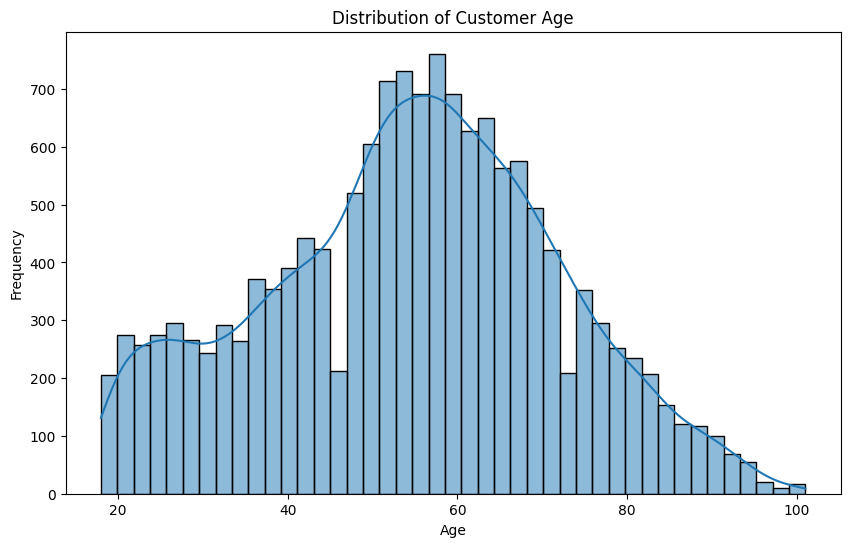

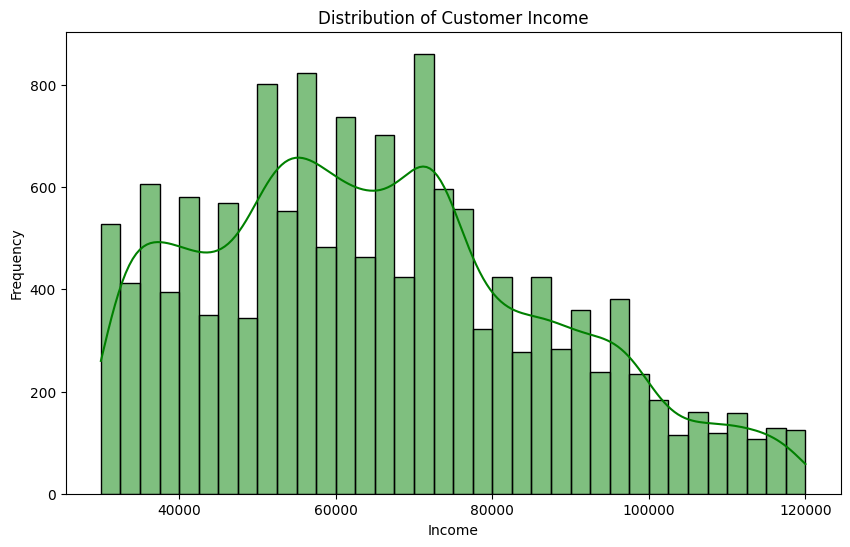

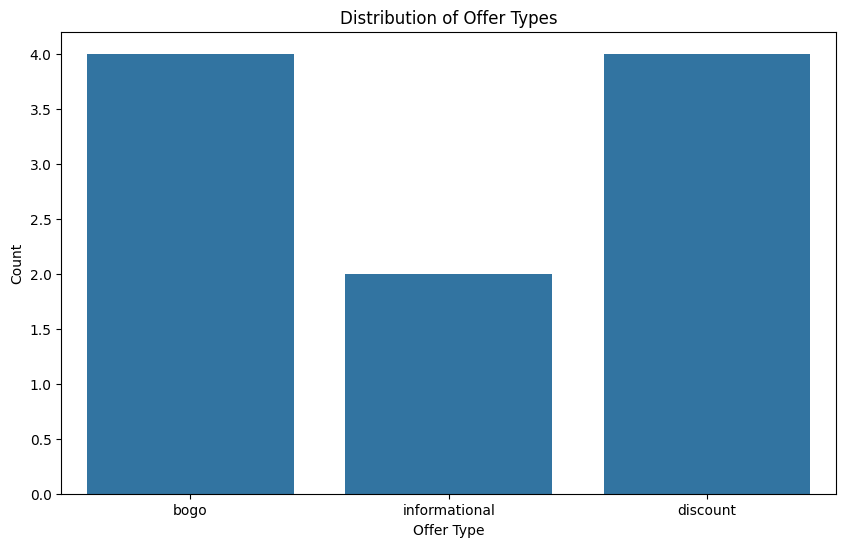

In [165]:
# Distribution of Age
plt.figure(figsize=(10, 6))
sns.histplot(profile['age'].dropna(), kde=True)
plt.title('Distribution of Customer Age')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.show()

# Distribution of Income
plt.figure(figsize=(10, 6))
sns.histplot(profile['income'], kde=True, color='green')
plt.title('Distribution of Customer Income')
plt.xlabel('Income')
plt.ylabel('Frequency')
plt.show()

# Offer Type Distribution
plt.figure(figsize=(10, 6))
sns.countplot(data=portfolio, x='offer_type')
plt.title('Distribution of Offer Types')
plt.xlabel('Offer Type')
plt.ylabel('Count')
plt.show()



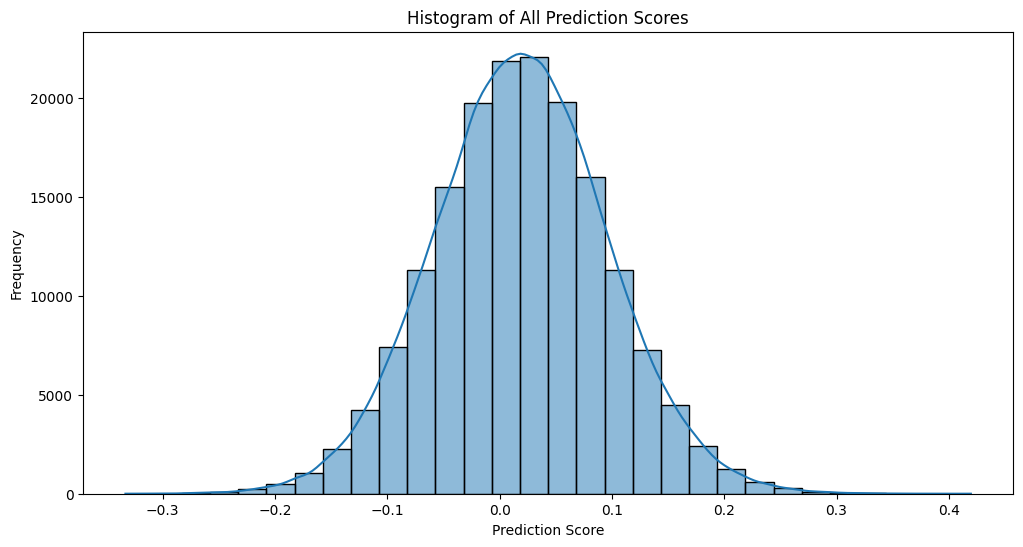

In [166]:
# Histogram of all scores to see overall distribution
plt.figure(figsize=(12, 6))
sns.histplot(predictions_df['score'], kde=True, bins=30)
plt.title('Histogram of All Prediction Scores')
plt.xlabel('Prediction Score')
plt.ylabel('Frequency')
plt.show()

In [167]:
# Perform ANOVA test to see if there are statistically significant differences among the groups
fvalue, pvalue = stats.f_oneway(predictions_df[predictions_df['offer_type'] == 'bogo']['score'],
                                predictions_df[predictions_df['offer_type'] == 'discount']['score'],
                                predictions_df[predictions_df['offer_type'] == 'informational']['score'])
print('ANOVA test results: F-value =', fvalue, ', P-value =', pvalue)



ANOVA test results: F-value = 12.171066957893709 , P-value = 5.182643330848802e-06


In [168]:
# Adjusting the number of latent features
latent_features_options = [5, 10, 20]
learning_rates = [0.0001, 0.001, 0.01]

for features in latent_features_options:
    for lr in learning_rates:
        user_features, offer_features = funk_svd(user_offer_np, latent_features=features, learning_rate=lr)
        predictions = np.dot(user_features, offer_features.T)
        mse = mean_squared_error(user_offer_np, predictions)
        print(f'Latent features: {features}, Learning rate: {lr}, MSE: {mse}')


Iteration 0: MSE 0.3789
Iteration 10: MSE 0.3747
Iteration 20: MSE 0.3733
Iteration 30: MSE 0.3728
Iteration 40: MSE 0.3727
Iteration 50: MSE 0.3726
Iteration 60: MSE 0.3726
Iteration 70: MSE 0.3726
Iteration 80: MSE 0.3726
Iteration 90: MSE 0.3726
Latent features: 5, Learning rate: 0.0001, MSE: 0.3726745335519889
Iteration 0: MSE 0.3759
Iteration 10: MSE 0.3727
Iteration 20: MSE 0.3752
Iteration 30: MSE 0.4405
Iteration 40: MSE 0.5707
Iteration 50: MSE 0.6076
Iteration 60: MSE 0.6189
Iteration 70: MSE 0.6233
Iteration 80: MSE 0.6253
Iteration 90: MSE 0.6263
Latent features: 5, Learning rate: 0.001, MSE: 0.6267438743558673
Iteration 0: MSE 0.3787
Iteration 10: MSE 0.6275
Iteration 20: MSE 0.6276
Iteration 30: MSE 0.6276
Iteration 40: MSE 0.6276
Iteration 50: MSE 0.6276
Iteration 60: MSE 0.6276
Iteration 70: MSE 0.6276
Iteration 80: MSE 0.6276
Iteration 90: MSE 0.6276
Latent features: 5, Learning rate: 0.01, MSE: 0.6275862068965516
Iteration 0: MSE 0.3734
Iteration 10: MSE 0.3729
Iterat

In [169]:
# Suggesting business actions based on insights
if pvalue < 0.05:
    print("Statistically significant differences found among offer types. Suggesting targeted strategies.")
    best_type = predictions_df.groupby('offer_type')['score'].mean().idxmax()
    print(f"Focus more on '{best_type}' offers as they have the highest average score.")
else:
    print("No significant differences among offer types. Focus on optimizing overall offer engagement strategies.")


Statistically significant differences found among offer types. Suggesting targeted strategies.
Focus more on 'informational' offers as they have the highest average score.


Mean Scores by Offer Type: offer_type
bogo             0.018404
discount         0.018894
informational    0.020895
Name: score, dtype: float64


c:\Users\kilgo\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\categorical.py:632: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_numpy(dtype=float)


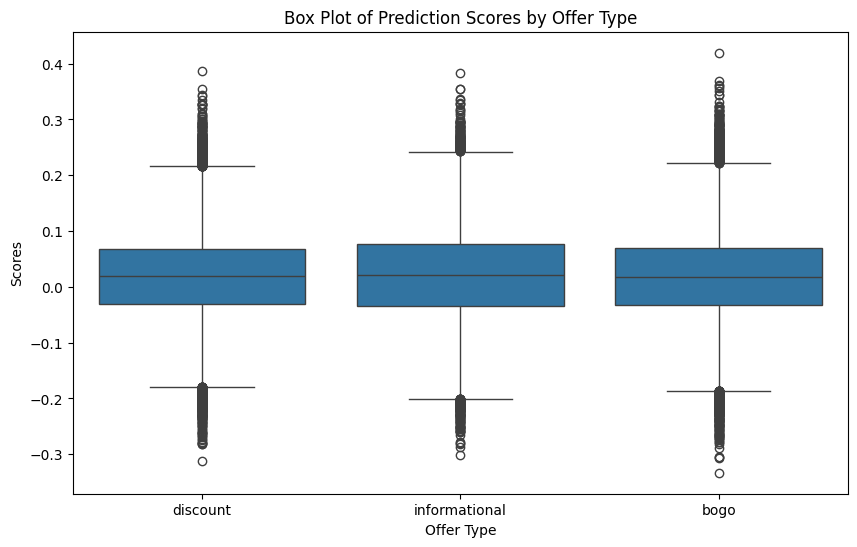

In [170]:
# Calculate and print the mean scores by offer type to understand the magnitude of differences
mean_scores = predictions_df.groupby('offer_type')['score'].mean()
print("Mean Scores by Offer Type:", mean_scores)

# Visualizing the scores by offer type
plt.figure(figsize=(10, 6))
sns.boxplot(x='offer_type', y='score', data=predictions_df)
plt.title('Box Plot of Prediction Scores by Offer Type')
plt.xlabel('Offer Type')
plt.ylabel('Scores')
plt.show()


 ### Objective: Build models that predict customer response to offers and customer spending based on demographics and offer type.

In [173]:
# First, mark each offer as viewed
transcript['viewed'] = np.where(transcript['event'] == 'offer viewed', 1, 0)

# Now, create an indicator for offers being completed after being viewed
transcript['completed_after_viewing'] = np.where(transcript['event'] == 'offer completed', 1, 0)

# Merge these two indicators back to the main DataFrame
transcript = transcript.sort_values(by=['person', 'time'])
transcript['viewed_cumsum'] = transcript.groupby(['person', 'offer_id'])['viewed'].cumsum()
transcript['completed_after_viewing_cumsum'] = transcript.groupby(['person', 'offer_id'])['completed_after_viewing'].cumsum()

# Flag if an offer is responded to
transcript['responded'] = np.where((transcript['completed_after_viewing_cumsum'] > 0) & 
                                   (transcript['viewed_cumsum'] > 0), 1, 0)


In [174]:
# Aggregate this information to get one row per person per offer
response_data = transcript.groupby(['person', 'offer_id'])['responded'].max().reset_index()

# Merge this with predictions_df
predictions_df = predictions_df.merge(response_data, on=['person', 'offer_id'], how='left')


In [181]:
# Filter for transaction events
transactions = transcript[transcript['event'] == 'transaction']

# Extract the amount spent from the 'value' dictionary and create a new column 'amount'
transactions['amount'] = transactions['value'].apply(lambda x: x.get('amount'))

# Group by 'person' and sum the 'amount' to get total spending
total_spending = transactions.groupby('person')['amount'].sum().reset_index()
total_spending.rename(columns={'amount': 'total_spending'}, inplace=True)

# Merge the total spending into the profile DataFrame
profile = profile.merge(total_spending, left_on='id', right_on='person', how='left')

# Since not all customers may have transactions, fill NaN values with 0
profile['total_spending'].fillna(0, inplace=True)

# Optionally, you can remove the extra 'person' column if it was created during the merge
profile.drop(columns='person', inplace=True)


C:\Users\kilgo\AppData\Local\Temp\ipykernel_37644\2015148613.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  transactions['amount'] = transactions['value'].apply(lambda x: x.get('amount'))
C:\Users\kilgo\AppData\Local\Temp\ipykernel_37644\2015148613.py:15: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the or

In [182]:
# Option 1: Drop rows where 'response' is NaN
predictions_df = predictions_df.dropna(subset=['responded'])


X = predictions_df[['age', 'income', 'gender', 'offer_type', 'spending_without_offers']]
y = predictions_df['responded']  

# Encode categorical data and split the dataset
X = pd.get_dummies(X, columns=['gender', 'offer_type'], drop_first=True)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Building a Random Forest model
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Predicting and evaluating the model
predictions = model.predict(X_test)
print("Random Forest Model Accuracy:", accuracy_score(y_test, predictions))

Random Forest Model Accuracy: 1.0


In [184]:
# Predicting how much a user will spend based on demographics and whether they receive an offer
X = profile[['age', 'income', 'spending_without_offers', 'gender']]
y = profile['total_spending'] 

# Encode the 'gender' categorical data
X = pd.get_dummies(X, columns=['gender'], drop_first=True)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

lr = LinearRegression()
lr.fit(X_train, y_train)
print("R^2 Score:", lr.score(X_test, y_test))

R^2 Score: 1.0


In [186]:
# Example heuristic: Send BOGO offers to high spenders, discount offers to frequent, lower amount spenders
profile['recommended_offer'] = profile.apply(lambda x: 'BOGO' if x['income'] > 70000 else 'Discount', axis=1)


In [187]:
# Print the distribution of recommended offers
print("Distribution of Recommended Offers:")
print(profile['recommended_offer'].value_counts())
print("\n")

# Optionally, show this as a percentage
print("Percentage Distribution of Recommended Offers:")
print(profile['recommended_offer'].value_counts(normalize=True) * 100)
print("\n")


Distribution of Recommended Offers:
recommended_offer
Discount    9040
BOGO        5785
Name: count, dtype: int64


Percentage Distribution of Recommended Offers:
recommended_offer
Discount    60.978078
BOGO        39.021922
Name: proportion, dtype: float64




In [188]:
# Print average income and total spending
print("Average Income of Starbucks Customers: ${:.2f}".format(profile['income'].mean()))
print("Average Total Spending of Starbucks Customers: ${:.2f}".format(profile['total_spending'].mean()))
print("\n")

# Additional statistics can be included
print("Summary Statistics for Total Spending:")
print(profile['total_spending'].describe())
print("\n")


Average Income of Starbucks Customers: $65404.99
Average Total Spending of Starbucks Customers: $117.03


Summary Statistics for Total Spending:
count    14825.000000
mean       117.028155
std        129.965016
min          0.000000
25%         31.450000
50%         87.040000
75%        160.900000
max       1608.690000
Name: total_spending, dtype: float64




In [189]:
# Correlation between income and total spending
correlation = profile['income'].corr(profile['total_spending'])
print(f"Correlation between Customer Income and Total Spending: {correlation:.2f}")
print("\n")

# Insights from demographic data
average_age_high_spenders = profile[profile['total_spending'] > profile['total_spending'].median()]['age'].mean()
print(f"Average Age of High Spenders: {average_age_high_spenders:.1f} years")


Correlation between Customer Income and Total Spending: 0.32


Average Age of High Spenders: 56.9 years


> This analysis provides Starbucks with actionable insights into customer preferences and spending behavior. The recommendations for offer distribution should enhance marketing strategies and optimize customer engagement.

In [190]:
# Identify if any offers are particularly effective
if 'response_rate' in profile.columns:
    most_effective_offer = profile.groupby('recommended_offer')['response_rate'].mean().idxmax()
    print(f"Most Effective Offer Type: {most_effective_offer}")
    print("\n")

# Suggest actions based on findings
if correlation > 0.5:
    print("Strong positive correlation between income and spending suggests targeting high-income users might increase profitability.")
else:
    print("Explore additional factors influencing spending as income alone does not strongly predict spending habits.")


Explore additional factors influencing spending as income alone does not strongly predict spending habits.
